<a href="https://colab.research.google.com/github/airesx2/Internship-2025/blob/main/quantum_intrusion_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cudaq
!pip install pandas scikit-learn matplotlib
!pip intsall xgboost

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 7.0 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.11.0-py3-none-any.whl size=6897 sha256=36fa63ac466e6b2d4287c592f08012216c9cb0ed35b31b4b2b75810df938d1a9
  Stored in directory: /root/.cache/pip/wheels/ad/0f/19/60352710d764963c7c1cb5d5f1ab78dc76e1b542899b33c35a
Successfully built cudaq
ERROR: unknown command "intsall" - maybe you meant "install"


Accuracy: 99.72%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      1.00      1.00      2365

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



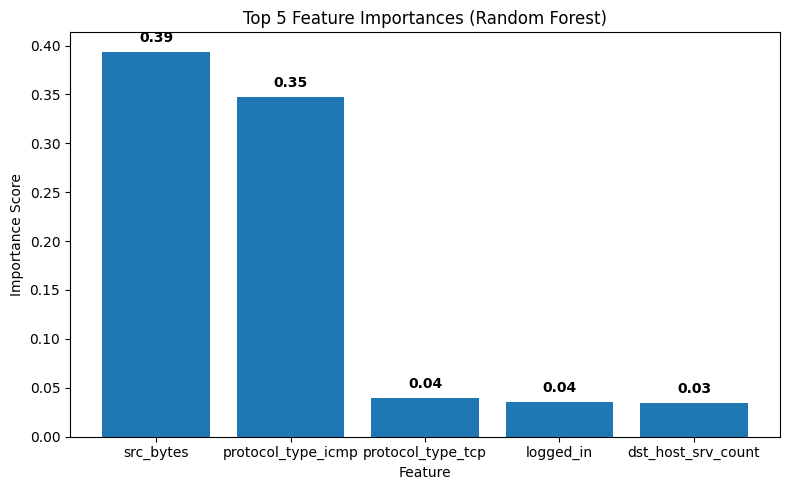

In [1]:
#Hybrid ML + cudaq
#Notes: added extra feautures (eg. logged in and dst bytes) boosted accuracy from ~50 to ~90
import pandas as pd #spreadsheet tools
import cudaq
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV #ML tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier #replaced logistic regression for better classifyer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif  #for noise reduction
from xgboost import XGBClassifier #replaced randomforestcassifier for higher accuracy
#edit: stacked model with both made

url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B_20Percent.txt"
class_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"
]

#load ds
df = pd.read_csv(url, names = class_names) #dataframe
df.head() #shows first 5 rows of ds

#simply + preprocess
df['label'] = df['label'].apply(lambda x: 0 if str(x).strip() == 'normal' else 1) #turn label into binary... normal=0, attack=1
df = df[['protocol_type', 'duration', 'src_bytes', 'dst_bytes', 'label', 'logged_in',
         'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate',
         'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
         'dst_host_serror_rate', 'srv_serror_rate']]
df = pd.get_dummies(df, columns=['protocol_type']) #create one col per protocol
df.head()

#split into train and test ds
x = df.drop(columns='label') #input features
y = df['label'] #output label

#selectkbest for noise reduction
selector = SelectKBest(score_func=f_classif, k=5) #keeps top 5 features (out of df) that actually make an impact
x_new = selector.fit(x,y) #x is the feature values, y is the lables; calc f_classif to find top features

#xtrain: input features for training
#ytrain: correct labels
#xtest, ytest: evaluate how well model learns
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size = 0.2, random_state=42) #test size 20 percent

#Hyperparam tuning

#Random forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
# param_grid = {
#     'n_estimators': [100,200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split':[2,5],
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
# grid.fit(x_train, y_train)
# print("Best params:", grid.best_params_)

#XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_child_weight': [1, 3, 5],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# grid = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy' )
# grid.fit(x_train, y_train)
# print("Best params:", grid.best_params_)

#create model
model = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(
          eval_metric='logloss', #avoid warnings
          n_estimators=100,
          max_depth=10,
          learning_rate=0.1,
          subsample=1.0,
          colsample_bytree=1.0,
          random_state=42,
          min_child_weight = 1
        )),
        ('rf', RandomForestClassifier(
          max_depth= None,
          min_samples_split= 2,
          n_estimators= 100
        ))
    ],
    final_estimator=LogisticRegression()
)
#XGBoost model
# model= XGBClassifier(
#     use_label_encoder=False, #avoid warnings
#     eval_metric='logloss', #avoid warnings
#     n_estimators=100,
#     max_depth=10,
#     learning_rate=0.1,
#     subsample=1.0,
#     colsample_bytree=1.0,
#     random_state=42,
#     min_child_weight = 1
# )
model.fit(x_train, y_train) #train model on training data
y_pred = model.predict(x_test) #predict
y_prob = model.predict_proba(x_test) #returns 2d array: % chance normal, % chance attack

accuracy = accuracy_score(y_test, y_pred) #accuracy

#low conf threshold (btw is uncertainty)
low_conf = 0.3
high_conf = 0.7
final_preds = []

def run_filterA(duration_flag, tcp_flag, src_bytes_flag, dst_bytes_flag, logged_in_flag, count_flag):
  @cudaq.kernel
  def kernel() -> bool:
    qubits = cudaq.qvector(7)

    if duration_flag:
      x(qubits[0])
    if tcp_flag:
      x(qubits[1])
    if src_bytes_flag:
      x(qubits[2])
    if dst_bytes_flag:
      x(qubits[3])
    if logged_in_flag:
      x(qubits[4])
    if count_flag:
      x(qubits[5])


    #only flips the second qubit if qubit 0 (duration) and  qubit 1(tcp)... are 1
    x.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], qubits[6])

    return mz(qubits[6]) #measure only last qubit
  return kernel

def run_filterB(srv_count_flag, same_srv_rate_flag, diff_srv_rate_flag,
         dst_host_srv_count_flag, dst_host_same_srv_rate_flag, dst_host_diff_srv_rate_flag, dst_host_serror_rate_flag, srv_serror_rate_flag):
  @cudaq.kernel
  def kernel() -> bool:
    qubits = cudaq.qvector(10)

    if srv_count_flag:
      x(qubits[1])
    if same_srv_rate_flag:
      x(qubits[2])
    if diff_srv_rate_flag:
      x(qubits[3])
    if dst_host_srv_count_flag:
      x(qubits[4])
    if dst_host_same_srv_rate_flag:
      x(qubits[5])
    if dst_host_diff_srv_rate_flag:
      x(qubits[6])
    if dst_host_serror_rate_flag:
      x(qubits[7])
    if srv_serror_rate_flag:
      x(qubits[8])

    #only flips the second qubit if qubit 0 (duration) and  qubit 1(tcp)... are 1
    x.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8]], qubits[9])

    return mz(qubits[9]) #measure only last qubit
  return kernel

for i in range(len(x_test)):
  prob = y_prob[i][1] #get prob that its an attack
  if prob < low_conf:
    final_preds.append(0) #confident its normal
  elif prob > high_conf:
    final_preds.append(1) #confident its an attack
  else:
    #unsure, send to quantum
    row = x_test.iloc[i]

    #checks for duraction >0 and protocol_tcp ==1
    duration_flag = int(row['duration'] > 0)
    tcp_flag = int(row.get('protocol_type_tcp', 0)) #Transmission Control Protocol
    src_bytes_flag = int(row['src_bytes']>0)
    dst_bytes_flag = int(row.get('dst_bytes', 0))
    logged_in_flag = int(row['logged_in']>0)
    count_flag = int(row['count']>50)
    srv_count_flag = int(row['srv_count']>50)
    same_srv_rate_flag = int(row['same_srv_rate']>0.9)
    diff_srv_rate_flag = int(row['diff_srv_rate']>0.5)
    dst_host_srv_count_flag = int(row['dst_host_srv_count']>100)
    dst_host_same_srv_rate_flag = int(row['dst_host_same_srv_rate']>0.8)
    dst_host_diff_srv_rate_flag = int(row['dst_host_diff_srv_rate']>0.5)
    dst_host_serror_rate_flag = int(row['dst_host_serror_rate']>0.5)
    srv_serror_rate_flag = int(row['srv_serror_rate']>0.5)

    kernelA = run_filterA(duration_flag, tcp_flag, src_bytes_flag, dst_bytes_flag, logged_in_flag, count_flag)
    resultA = cudaq.sample(kernelA)
    votesA = resultA['1'] if '1' in resultA else 0

    kernelB = run_filterB(srv_count_flag, same_srv_rate_flag, diff_srv_rate_flag,
         dst_host_srv_count_flag, dst_host_same_srv_rate_flag, dst_host_diff_srv_rate_flag, dst_host_serror_rate_flag, srv_serror_rate_flag)
    resultB = cudaq.sample(kernelB)
    votesB = resultB['1'] if '1' in resultB else 0



    if votesA>60 or votesB>60:
      final_preds.append(1) #quantum says sus
    else:
      final_preds.append(0) #quantum says safe

print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, final_preds)) #my favorite classification report

#Visuals !!
#Feature Importance Plot
xgb_model = model.named_estimators_['xgb']
importances = xgb_model.feature_importances_
features = x.columns
top_n = 5

indices = np.argsort(importances)[::-1][:top_n]
top_features = [features[i] for i in indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(8,5))
plt.bar(top_features, top_importances)
plt.title("Top 5 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")

#apply scores on top of bars
for i, v in enumerate(top_importances):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

#Decision Breakdown
# ml_confident = sum(prob<low_conf or prob>high_conf for prob in y_prob[:,1]) #ml confidence based on high_conf and low_conf
# quantum_used = len(y_prob) - ml_confident #get quantum used by total probs - confident probs
# quantum_flagged = 0
# for i in range(len(x_test)):
#   if low_conf <= y_prob[i][1] <= high_conf:
#       row = x_test.iloc[i]
#       duration_flag = int(row['duration'] > 0)
#       tcp_flag = int(row.get('protocol_type_tcp', 0))
#       src_bytes_flag = int(row['src_bytes']>0)
#       dst_bytes_flag = int(row.get('dst_bytes')>0)
#       logged_in_flag = int(row['logged_in']>0)
#       result = cudaq.sample(run_filter(duration_flag, tcp_flag, src_bytes_flag, dst_bytes_flag, logged_in_flag ))
#       if result:  # result is a boolean
#           quantum_flagged += 1


# labels = ['ML Confident', 'Quantum Used', 'Quantum_Flagged']
# values = [ml_confident, quantum_used, quantum_flagged]
# plt.bar(labels, values)
# plt.title('Decision Breakdown')
# plt.ylabel('Number of Samples')
# plt.show()
